# **Transcription with YourMT3+**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import shutil

selected_folders = ['amt', 'examples', 'model_output', 'sample_data']
drive_base = '/content/drive/MyDrive'

for folder in selected_folders:
    src = f'{drive_base}/{folder}'
    dst = f'/content/{folder}'
    shutil.copytree(src, dst, dirs_exist_ok=True)

!pip install awscli
!mkdir amt
!aws s3 sync s3://amt-deploy-public/amt/ /content/amt --no-sign-request
!aws s3 sync s3://amt-deploy-public/examples/ /content/examples --no-sign-request
%cd amt/src
!pip install -r requirements.txt
!pip install transformers==4.45.1
!apt-get install sox
!pip install pytube
!python -m pip install -U yt-dlp[default]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/amt'

In [ ]:
# @title Model helper
%cd /content/amt/src
from collections import Counter
import argparse
import torch
import numpy as np

from model.init_train import initialize_trainer, update_config
from utils.task_manager import TaskManager
from config.vocabulary import drum_vocab_presets
from utils.utils import str2bool
from utils.utils import Timer
from utils.audio import slice_padded_array
from utils.note2event import mix_notes
from utils.event2note import merge_zipped_note_events_and_ties_to_notes
from utils.utils import write_model_output_as_midi, write_err_cnt_as_json
from model.ymt3 import YourMT3

def load_model_checkpoint(args=None):
    parser = argparse.ArgumentParser(description="YourMT3")
    # General
    parser.add_argument('exp_id', type=str, help='A unique identifier for the experiment is used to resume training. The "@" symbol can be used to load a specific checkpoint.')
    parser.add_argument('-p', '--project', type=str, default='ymt3', help='project name')
    parser.add_argument('-ac', '--audio-codec', type=str, default=None, help='audio codec (default=None). {"spec", "melspec"}. If None, default value defined in config.py will be used.')
    parser.add_argument('-hop', '--hop-length', type=int, default=None, help='hop length in frames (default=None). {128, 300} 128 for MT3, 300 for PerceiverTFIf None, default value defined in config.py will be used.')
    parser.add_argument('-nmel', '--n-mels', type=int, default=None, help='number of mel bins (default=None). If None, default value defined in config.py will be used.')
    parser.add_argument('-if', '--input-frames', type=int, default=None, help='number of audio frames for input segment (default=None). If None, default value defined in config.py will be used.')
    # Model configurations
    parser.add_argument('-sqr', '--sca-use-query-residual', type=str2bool, default=None, help='sca use query residual flag. Default follows config.py')
    parser.add_argument('-enc', '--encoder-type', type=str, default=None, help="Encoder type. 't5' or 'perceiver-tf' or 'conformer'. Default is 't5', following config.py.")
    parser.add_argument('-dec', '--decoder-type', type=str, default=None, help="Decoder type. 't5' or 'multi-t5'. Default is 't5', following config.py.")
    parser.add_argument('-preenc', '--pre-encoder-type', type=str, default='default', help="Pre-encoder type. None or 'conv' or 'default'. By default, t5_enc:None, perceiver_tf_enc:conv, conformer:None")
    parser.add_argument('-predec', '--pre-decoder-type', type=str, default='default', help="Pre-decoder type. {None, 'linear', 'conv1', 'mlp', 'group_linear'} or 'default'. Default is {'t5': None, 'perceiver-tf': 'linear', 'conformer': None}.")
    parser.add_argument('-cout', '--conv-out-channels', type=int, default=None, help='Number of filters for pre-encoder conv layer. Default follows "model_cfg" of config.py.')
    parser.add_argument('-tenc', '--task-cond-encoder', type=str2bool, default=True, help='task conditional encoder (default=True). True or False')
    parser.add_argument('-tdec', '--task-cond-decoder', type=str2bool, default=True, help='task conditional decoder (default=True). True or False')
    parser.add_argument('-df', '--d-feat', type=int, default=None, help='Audio feature will be projected to this dimension for Q,K,V of T5 or K,V of Perceiver (default=None). If None, default value defined in config.py will be used.')
    parser.add_argument('-pt', '--pretrained', type=str2bool, default=False, help='pretrained T5(default=False). True or False')
    parser.add_argument('-b', '--base-name', type=str, default="google/t5-v1_1-small", help='base model name (default="google/t5-v1_1-small")')
    parser.add_argument('-epe', '--encoder-position-encoding-type', type=str, default='default', help="Positional encoding type of encoder. By default, pre-defined PE for T5 or Perceiver-TF encoder in config.py. For T5: {'sinusoidal', 'trainable'}, conformer: {'rotary', 'trainable'}, Perceiver-TF: {'trainable', 'rope', 'alibi', 'alibit', 'None', '0', 'none', 'tkd', 'td', 'tk', 'kdt'}.")
    parser.add_argument('-dpe', '--decoder-position-encoding-type', type=str, default='default', help="Positional encoding type of decoder. By default, pre-defined PE for T5 in config.py. {'sinusoidal', 'trainable'}.")
    parser.add_argument('-twe', '--tie-word-embedding', type=str2bool, default=None, help='tie word embedding (default=None). If None, default value defined in config.py will be used.')
    parser.add_argument('-el', '--event-length', type=int, default=None, help='event length (default=None). If None, default value defined in model cfg of config.py will be used.')
    # Perceiver-TF configurations
    parser.add_argument('-dl', '--d-latent', type=int, default=None, help='Latent dimension of Perceiver. On T5, this will be ignored (default=None). If None, default value defined in config.py will be used.')
    parser.add_argument('-nl', '--num-latents', type=int, default=None, help='Number of latents of Perceiver. On T5, this will be ignored (default=None). If None, default value defined in config.py will be used.')
    parser.add_argument('-dpm', '--perceiver-tf-d-model', type=int, default=None, help='Perceiver-TF d_model (default=None). If None, default value defined in config.py will be used.')
    parser.add_argument('-npb', '--num-perceiver-tf-blocks', type=int, default=None, help='Number of blocks of Perceiver-TF. On T5, this will be ignored (default=None). If None, default value defined in config.py.')
    parser.add_argument('-npl', '--num-perceiver-tf-local-transformers-per-block', type=int, default=None, help='Number of local layers per block of Perceiver-TF. On T5, this will be ignored (default=None). If None, default value defined in config.py will be used.')
    parser.add_argument('-npt', '--num-perceiver-tf-temporal-transformers-per-block', type=int, default=None, help='Number of temporal layers per block of Perceiver-TF. On T5, this will be ignored (default=None). If None, default value defined in config.py will be used.')
    parser.add_argument('-atc', '--attention-to-channel', type=str2bool, default=None, help='Attention to channel flag of Perceiver-TF. On T5, this will be ignored (default=None). If None, default value defined in config.py will be used.')
    parser.add_argument('-ln', '--layer-norm-type', type=str, default=None, help='Layer normalization type (default=None). {"layer_norm", "rms_norm"}. If None, default value defined in config.py will be used.')
    parser.add_argument('-ff', '--ff-layer-type', type=str, default=None, help='Feed forward layer type (default=None). {"mlp", "moe", "gmlp"}. If None, default value defined in config.py will be used.')
    parser.add_argument('-wf', '--ff-widening-factor', type=int, default=None, help='Feed forward layer widening factor for MLP/MoE/gMLP (default=None). If None, default value defined in config.py will be used.')
    parser.add_argument('-nmoe', '--moe-num-experts', type=int, default=None, help='Number of experts for MoE (default=None). If None, default value defined in config.py will be used.')
    parser.add_argument('-kmoe', '--moe-topk', type=int, default=None, help='Top-k for MoE (default=None). If None, default value defined in config.py will be used.')
    parser.add_argument('-act', '--hidden-act', type=str, default=None, help='Hidden activation function (default=None). {"gelu", "silu", "relu", "tanh"}. If None, default value defined in config.py will be used.')
    parser.add_argument('-rt', '--rotary-type', type=str, default=None, help='Rotary embedding type expressed in three letters. e.g. ppl: "pixel" for SCA and latents, "lang" for temporal transformer. If None, use config.')
    parser.add_argument('-rk', '--rope-apply-to-keys', type=str2bool, default=None, help='Apply rope to keys (default=None). If None, use config.')
    parser.add_argument('-rp', '--rope-partial-pe', type=str2bool, default=None, help='Whether to apply RoPE to partial positions (default=None). If None, use config.')
    # Decoder configurations
    parser.add_argument('-dff', '--decoder-ff-layer-type', type=str, default=None, help='Feed forward layer type of decoder (default=None). {"mlp", "moe", "gmlp"}. If None, default value defined in config.py will be used.')
    parser.add_argument('-dwf', '--decoder-ff-widening-factor', type=int, default=None, help='Feed forward layer widening factor for decoder MLP/MoE/gMLP (default=None). If None, default value defined in config.py will be used.')
    # Task and Evaluation configurations
    parser.add_argument('-tk', '--task', type=str, default='mt3_full_plus', help='tokenizer type (default=mt3_full_plus). See config/task.py for more options.')
    parser.add_argument('-epv', '--eval-program-vocab', type=str, default=None, help='evaluation vocabulary (default=None). If None, default vocabulary of the data preset will be used.')
    parser.add_argument('-edv', '--eval-drum-vocab', type=str, default=None, help='evaluation vocabulary for drum (default=None). If None, default vocabulary of the data preset will be used.')
    parser.add_argument('-etk', '--eval-subtask-key', type=str, default='default', help='evaluation subtask key (default=default). See config/task.py for more options.')
    parser.add_argument('-t', '--onset-tolerance', type=float, default=0.05, help='onset tolerance (default=0.05).')
    parser.add_argument('-os', '--test-octave-shift', type=str2bool, default=False, help='test optimal octave shift (default=False). True or False')
    parser.add_argument('-w', '--write-model-output', type=str2bool, default=True, help='write model test output to file (default=False). True or False')
    # Trainer configurations
    parser.add_argument('-pr','--precision', type=str, default="bf16-mixed", help='precision (default="bf16-mixed") {32, 16, bf16, bf16-mixed}')
    parser.add_argument('-st', '--strategy', type=str, default='auto', help='strategy (default=auto). auto or deepspeed or ddp')
    parser.add_argument('-n', '--num-nodes', type=int, default=1, help='number of nodes (default=1)')
    parser.add_argument('-g', '--num-gpus', type=str, default='auto', help='number of gpus (default="auto")')
    parser.add_argument('-wb', '--wandb-mode', type=str, default="disabled", help='wandb mode for logging (default=None). "disabled" or "online" or "offline". If None, default value defined in config.py will be used.')
    # Debug
    parser.add_argument('-debug', '--debug-mode', type=str2bool, default=False, help='debug mode (default=False). True or False')
    parser.add_argument('-tps', '--test-pitch-shift', type=int, default=None, help='use pitch shift when testing. debug-purpose only. (default=None). semitone in int.')
    args = parser.parse_args(args)
    # yapf: enable
    if torch.__version__ >= "1.13":
        torch.set_float32_matmul_precision("high")
    args.epochs = None

    # Initialize and update config
    _, _, dir_info, shared_cfg = initialize_trainer(args, stage='test')
    shared_cfg, audio_cfg, model_cfg = update_config(args, shared_cfg, stage='test')

    if args.eval_drum_vocab != None:  # override eval_drum_vocab
        eval_drum_vocab = drum_vocab_presets[args.eval_drum_vocab]

    # Initialize task manager
    tm = TaskManager(task_name=args.task,
                     max_shift_steps=int(shared_cfg["TOKENIZER"]["max_shift_steps"]),
                     debug_mode=args.debug_mode)
    print(f"Task: {tm.task_name}, Max Shift Steps: {tm.max_shift_steps}")

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model
    model = YourMT3(
        audio_cfg=audio_cfg,
        model_cfg=model_cfg,
        shared_cfg=shared_cfg,
        optimizer=None,
        task_manager=tm,  # tokenizer is a member of task_manager
        eval_subtask_key=args.eval_subtask_key,
        write_output_dir=dir_info["lightning_dir"] if args.write_model_output or args.test_octave_shift else None
        ).to(device)
    checkpoint = torch.load(dir_info["last_ckpt_path"], weights_only=False) # fix model loading error in torch 2.6
    state_dict = checkpoint['state_dict']
    new_state_dict = {k: v for k, v in state_dict.items() if 'pitchshift' not in k}
    model.load_state_dict(new_state_dict, strict=False)
    return model.eval()


def transcribe(model, audio_info):
    t = Timer()

    # Converting Audio
    t.start()
    audio, sr = torchaudio.load(uri=audio_info['filepath'])
    audio = torch.mean(audio, dim=0).unsqueeze(0)
    audio = torchaudio.functional.resample(audio, sr, model.audio_cfg['sample_rate'])
    audio_segments = slice_padded_array(audio, model.audio_cfg['input_frames'], model.audio_cfg['input_frames'])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    audio_segments = torch.from_numpy(audio_segments.astype('float32')).to(device).unsqueeze(1) # (n_seg, 1, seg_sz)
    t.stop(); t.print_elapsed_time("converting audio");

    # Inference
    t.start()
    pred_token_arr, _ = model.inference_file(bsz=8, audio_segments=audio_segments)
    t.stop(); t.print_elapsed_time("model inference");

    # Post-processing
    t.start()
    num_channels = model.task_manager.num_decoding_channels
    n_items = audio_segments.shape[0]
    start_secs_file = [model.audio_cfg['input_frames'] * i / model.audio_cfg['sample_rate'] for i in range(n_items)]
    pred_notes_in_file = []
    n_err_cnt = Counter()
    for ch in range(num_channels):
        pred_token_arr_ch = [arr[:, ch, :] for arr in pred_token_arr]  # (B, L)
        zipped_note_events_and_tie, list_events, ne_err_cnt = model.task_manager.detokenize_list_batches(
            pred_token_arr_ch, start_secs_file, return_events=True)
        pred_notes_ch, n_err_cnt_ch = merge_zipped_note_events_and_ties_to_notes(zipped_note_events_and_tie)
        pred_notes_in_file.append(pred_notes_ch)
        n_err_cnt += n_err_cnt_ch
    pred_notes = mix_notes(pred_notes_in_file)  # This is the mixed notes from all channels

    # Write MIDI
    write_model_output_as_midi(pred_notes, '/content/',
                              audio_info['track_name'], model.midi_output_inverse_vocab)
    t.stop(); t.print_elapsed_time("post processing");
    midifile =  os.path.join('/content/model_output/', audio_info['track_name']  + '.mid')
    assert os.path.exists(midifile)
    return midifile


In [ ]:
# @title Load Checkpoint
model_name = 'YPTF.MoE+Multi (noPS)' # @param ["YMT3+", "YPTF+Single (noPS)", "YPTF+Multi (PS)", "YPTF.MoE+Multi (noPS)", "YPTF.MoE+Multi (PS)"]
precision = 'bf16-mixed' # @param ["32", "bf16-mixed", "16"]
project = '2024'

if model_name == "YMT3+":
    checkpoint = "notask_all_cross_v6_xk2_amp0811_gm_ext_plus_nops_b72@model.ckpt"
    args = [checkpoint, '-p', project, '-pr', precision]
elif model_name == "YPTF+Single (noPS)":
    checkpoint = "ptf_all_cross_rebal5_mirst_xk2_edr005_attend_c_full_plus_b100@model.ckpt"
    args = [checkpoint, '-p', project, '-enc', 'perceiver-tf', '-ac', 'spec',
            '-hop', '300', '-atc', '1', '-pr', precision]
elif model_name == "YPTF+Multi (PS)":
    checkpoint = "mc13_256_all_cross_v6_xk5_amp0811_edr005_attend_c_full_plus_2psn_nl26_sb_b26r_800k@model.ckpt"
    args = [checkpoint, '-p', project, '-tk', 'mc13_full_plus_256',
            '-dec', 'multi-t5', '-nl', '26', '-enc', 'perceiver-tf',
            '-ac', 'spec', '-hop', '300', '-atc', '1', '-pr', precision]
elif model_name == "YPTF.MoE+Multi (noPS)":
    checkpoint = "mc13_256_g4_all_v7_mt3f_sqr_rms_moe_wf4_n8k2_silu_rope_rp_b36_nops@last.ckpt"
    args = [checkpoint, '-p', project, '-tk', 'mc13_full_plus_256', '-dec', 'multi-t5',
            '-nl', '26', '-enc', 'perceiver-tf', '-sqr', '1', '-ff', 'moe',
            '-wf', '4', '-nmoe', '8', '-kmoe', '2', '-act', 'silu', '-epe', 'rope',
            '-rp', '1', '-ac', 'spec', '-hop', '300', '-atc', '1', '-pr', precision]
elif model_name == "YPTF.MoE+Multi (PS)":
    checkpoint = "mc13_256_g4_all_v7_mt3f_sqr_rms_moe_wf4_n8k2_silu_rope_rp_b80_ps2@model.ckpt"
    args = [checkpoint, '-p', project, '-tk', 'mc13_full_plus_256', '-dec', 'multi-t5',
            '-nl', '26', '-enc', 'perceiver-tf', '-sqr', '1', '-ff', 'moe',
            '-wf', '4', '-nmoe', '8', '-kmoe', '2', '-act', 'silu', '-epe', 'rope',
            '-rp', '1', '-ac', 'spec', '-hop', '300', '-atc', '1', '-pr', precision]
else:
    raise ValueError(model_name)

model = load_model_checkpoint(args=args)

In [ ]:

audio_info = {'filepath': input_audio, 'track_name': track_name}
midi_path = transcribe(model, audio_info)

print("Transcription complete! MIDI file saved to:", midi_path)


files.download(midi_path)

# **Parangonar Matching**

In [ ]:
!pip install pretty_midi
!pip install parangonar
import parangonar as pa
import partitura as pt
from google.colab import files
import numpy as np
import numpy.lib.recfunctions as rfn
import re

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 45.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.2 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=4550e7c2287f53ed63e75219bcbda8851d9231fef80b52538bb5f47f03b2e8bf
  Stored in directory: /root/.cache/pip/wheels/a4/f9/9e/08350c27e386558df0ae234e28a8facd145ba45506ddd1b989
Successfully built pretty_midi
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.3/350.3 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.0/159.0 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.5/458.5 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [ ]:


print(f"Upload your score as a MIDI file.")
uploaded_files = files.upload()


midi_files = list(uploaded_files.keys())
midi_score = midi_files[0]

print(f"Upload your transcribed audio as a MIDI file.")
uploaded_files = files.upload()

user_input = input("Enter the bpm: ")
bpm = int(user_input)

midi_files = list(uploaded_files.keys())
midi_perf = midi_files[0]

score_match = pt.load_score_midi(midi_score)
perf_match = pt.load_performance_midi(midi_perf)

pna_match = perf_match.note_array()
sna_match = score_match.note_array()


Upload your score as a MIDI file.


Saving DirtC#110True.mid to DirtC#110True.mid
Upload your transcribed audio as a MIDI file.


Saving DirtD130.mid to DirtD130.mid
Enter the bpm: 130


/usr/local/lib/python3.12/dist-packages/partitura/io/importmidi.py:576: UserWarning: pitch spelling
  warnings.warn("pitch spelling")
/usr/local/lib/python3.12/dist-packages/partitura/io/importmidi.py:661: UserWarning: create_part
  part = create_part(
/usr/local/lib/python3.12/dist-packages/partitura/io/importmidi.py:661: UserWarning: add notes
  part = create_part(
/usr/local/lib/python3.12/dist-packages/partitura/io/importmidi.py:661: UserWarning: add time sigs and measures
  part = create_part(
/usr/local/lib/python3.12/dist-packages/partitura/io/importmidi.py:661: UserWarning: tie notes
  part = create_part(
/usr/local/lib/python3.12/dist-packages/partitura/io/importmidi.py:661: UserWarning: find tuplets
  part = create_part(
/usr/local/lib/python3.12/dist-packages/partitura/io/importmidi.py:661: UserWarning: done create_part
  part = create_part(


In [ ]:
original_pna = pna_match.copy()
for i, note in enumerate(pna_match):
    note['id'] = f'n{i}'
    note['onset_sec'] -= pna_match[0]['onset_sec']
matcher = pa.TheGlueNoteMatcher()
pred_alignment = matcher(sna_match,
                         pna_match)

DTW local path time:  2.5159597396850586
PATH length: 233 (132, 111)


In [ ]:
pa.plot_alignment(pna_match, sna_match, pred_alignment)

ValueError: could not broadcast input array from shape (128,11210) into shape (128,10800)

In [ ]:
import numpy as np
import re
import copy

def compute_accuracy(pred_alignment, sna_match, pna_match, bpm, tolerance_beats=0.075, percentile_cutoff=0.95):
    beat_duration = 60 / bpm

    def extract_index(note_id):
        if note_id is None:
            return None
        match = re.search(r'n(\d+)', str(note_id))
        return int(match.group(1)) if match else None

    cleaned_alignment = copy.deepcopy(pred_alignment)
    pna_match = copy.deepcopy(pna_match)

    score_to_perf = {}
    perf_to_score = {}
    deletions = {}
    used_perf_notes = set()

    for match in cleaned_alignment:
        label = match.get('label')
        s_idx = extract_index(match.get('score_id'))
        p_idx = extract_index(match.get('performance_id'))
        if s_idx is None:
            continue
        if label == 'match' and p_idx is not None:
            score_to_perf[s_idx] = p_idx
            perf_to_score[p_idx] = s_idx
            used_perf_notes.add(p_idx)
        elif label == 'deletion':
            deletions[s_idx] = p_idx

    matched_score_idxs = set(score_to_perf.keys())

    if matched_score_idxs:
        sna_onsets_sec = np.array([sna_match[s]['onset_beat'] * beat_duration for s in matched_score_idxs])
        pna_onsets_sec = np.array([pna_match[score_to_perf[s]]['onset_sec'] for s in matched_score_idxs])
        offset = np.median(pna_onsets_sec - sna_onsets_sec)
        for i in range(len(pna_match)):
            pna_match[i]['onset_sec'] -= offset

    def perf_candidates_in_context(s_idx):
        prev_idx = max([i for i in matched_score_idxs if i < s_idx], default=None)
        next_idx = min([i for i in matched_score_idxs if i > s_idx], default=None)
        prev_onset = sna_match[prev_idx]['onset_beat'] * beat_duration if prev_idx is not None else -float('inf')
        next_onset = sna_match[next_idx]['onset_beat'] * beat_duration if next_idx is not None else float('inf')
        return [(pi, pna_match[pi]) for pi in range(len(pna_match))
                if pi not in used_perf_notes and prev_onset <= pna_match[pi]['onset_sec'] <= next_onset]

    for s_idx in sorted(deletions.keys()):
        score_note = sna_match[s_idx]
        score_pitch = score_note['pitch']
        provided_p_idx = deletions[s_idx]
        found_perf = None
        if provided_p_idx is not None and 0 <= provided_p_idx < len(pna_match) and provided_p_idx not in used_perf_notes:
            found_perf = (provided_p_idx, pna_match[provided_p_idx])
        if found_perf is None:
            candidates = perf_candidates_in_context(s_idx)
            if candidates:
                best_p_idx, best_perf_note = min(
                    candidates,
                    key=lambda x: abs(x[1]['onset_sec']/beat_duration - score_note['onset_beat']) + abs(x[1]['pitch'] - score_pitch)/12
                )
                found_perf = (best_p_idx, best_perf_note)
        if found_perf is not None:
            p_idx, perf_note = found_perf
            used_perf_notes.add(p_idx)
            cleaned_alignment.append({'label': 'match', 'score_id': score_note['id'], 'performance_id': perf_note['id']})
            score_to_perf[s_idx] = p_idx
            perf_to_score[p_idx] = s_idx
            matched_score_idxs.add(s_idx)

    timing_errors = []
    for s_idx in sorted(score_to_perf.keys()):
        score_note = sna_match[s_idx]
        p_idx = score_to_perf[s_idx]
        perf_note = pna_match[p_idx]
        onset_error = abs(perf_note['onset_sec']/beat_duration - score_note['onset_beat'])
        timing_errors.append(onset_error)

    threshold = np.percentile(timing_errors, percentile_cutoff*100)
    filtered_score_idxs = [s_idx for s_idx, err in zip(sorted(score_to_perf.keys()), timing_errors) if err <= threshold]

    filtered_alignment = [a for a in cleaned_alignment if extract_index(a.get('score_id')) in filtered_score_idxs]

    filtered_errors = [err for s_idx, err in zip(sorted(score_to_perf.keys()), timing_errors) if s_idx in filtered_score_idxs]
    timing_accuracy = 100 * sum(e <= tolerance_beats for e in filtered_errors) / len(filtered_errors) if filtered_errors else 0

    correct_pitches = 0
    for s_idx in filtered_score_idxs:
        score_note = sna_match[s_idx]
        p_idx = score_to_perf[s_idx]
        actual_pitch = pna_match[p_idx]['pitch']
        score_pitch = score_note['pitch']
        if ((actual_pitch - score_pitch) % 12 == 0) and (actual_pitch != score_pitch):
            eval_pitch = score_pitch
            pna_match[p_idx]['pitch'] = score_pitch
        else:
            eval_pitch = actual_pitch
        if eval_pitch == score_pitch:
            correct_pitches += 1
    pitch_accuracy = 100 * correct_pitches / len(filtered_score_idxs) if filtered_score_idxs else 0

    return pna_match, pitch_accuracy, timing_accuracy, filtered_errors, filtered_alignment, threshold


In [ ]:
fixed_pna, pitch_accuracy, timing_accuracy, filtered_errors, filtered_alignment, threshold = compute_accuracy(pred_alignment, sna_match, pna_match, bpm)
print(f"Pitch Accuracy: {pitch_accuracy:.2f}%")
print(f"Timing Accuracy: {timing_accuracy:.2f}%")
pna_match = fixed_pna

Pitch Accuracy: 12.50%
Timing Accuracy: 56.25%


In [ ]:
arr = np.array(filtered_errors, dtype=np.float32)
print(f"Threshold: {threshold}")
np.set_printoptions(precision=5, suppress=True)
print(arr)

Threshold: 6.017795085906982
[0.01424 0.04757 0.03802 0.0059  0.03924 0.00712 0.01788 0.01198 0.02135
 0.01076 0.02031 0.00955 0.02378 0.02865 0.025   0.00712 0.01667 0.00365
 0.01545 0.00243 0.22865 0.24045 0.27031 0.51788 0.98333 1.29531 0.00712
 0.05955 0.28576 1.52864 0.0441  0.05365 0.      0.03212 0.0191  0.225
 0.21198 0.22378 0.23333 0.22031 0.23212 0.45833 0.75    0.99878 1.00833
 0.99531 1.2441  3.0309 ]


In [ ]:
pa.plot_alignment(pna_match, sna_match, filtered_alignment)

ValueError: could not broadcast input array from shape (128,11210) into shape (128,10800)

# Calibration

In [ ]:
from google.colab import files
print("Upload your calibration audio as a WAV file.")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
user_input = input("Enter the bpm (Default is 60): ")
calibration_bpm = int(user_input)

Upload your calibration audio as a WAV file.


Saving VihaanDynamicsCalibration (mp3cut.net).wav to VihaanDynamicsCalibration (mp3cut.net).wav
Enter the bpm (Default is 60): 60


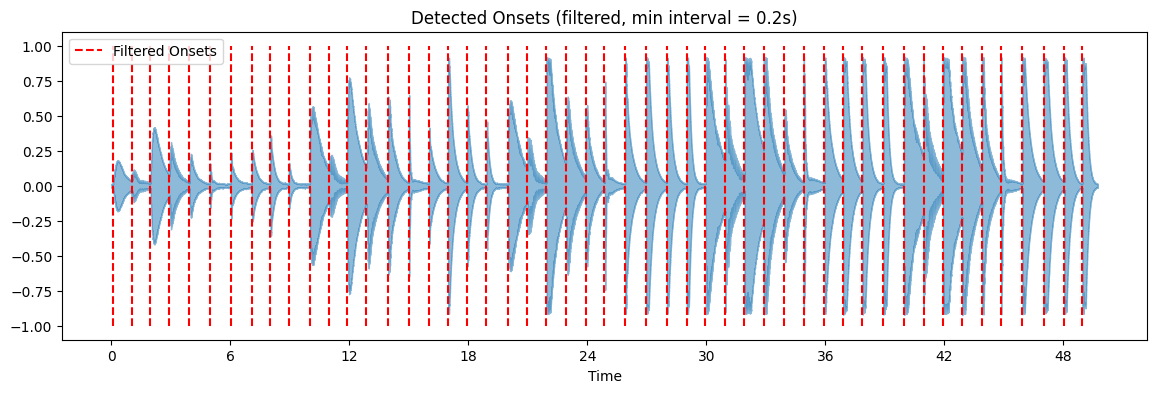

Filtered onsets (in seconds):
1: 0.075
2: 1.024
3: 1.963
4: 2.901
5: 3.925
6: 4.960
7: 6.016
8: 7.072
9: 8.011
10: 8.939
11: 10.016
12: 10.976
13: 11.893
14: 12.864
15: 13.941
16: 14.987
17: 16.000
18: 16.960
19: 17.941
20: 18.901
21: 19.989
22: 20.981
23: 21.909
24: 22.912
25: 23.915
26: 24.853
27: 25.909
28: 26.965
29: 28.011
30: 29.003
31: 29.941
32: 30.955
33: 31.904
34: 32.885
35: 33.909
36: 34.912
37: 35.957
38: 36.896
39: 37.867
40: 38.923
41: 39.968
42: 40.960
43: 41.931
44: 42.880
45: 43.904
46: 44.843
47: 45.931
48: 47.019
49: 48.053
50: 48.960


In [ ]:
!pip install librosa
import librosa
import librosa.display
import matplotlib.pyplot as plt


y, sr = librosa.load(filename, sr=48000)

onset_times = librosa.onset.onset_detect(y=y, sr=sr, units='time', backtrack=True)
onset_times = list(onset_times)

min_interval = 0.2
filtered_onsets = []
for t in onset_times:
    if len(filtered_onsets) == 0 or (t - filtered_onsets[-1]) >= min_interval:
        filtered_onsets.append(t)

plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.vlines(filtered_onsets, ymin=-1, ymax=1, color='r', linestyle='--', label='Filtered Onsets')
plt.title(f"Detected Onsets (filtered, min interval = {min_interval}s)")
plt.legend()
plt.show()

print("Filtered onsets (in seconds):")
for i, t in enumerate(filtered_onsets):
    print(f"{i+1}: {t:.3f}")


In [ ]:
import os
import soundfile as sf
import numpy as np

proportion = 0.9
output_dir = "sliced_notes"

os.makedirs(output_dir, exist_ok=True)


beat_duration = 60 / calibration_bpm
note_duration_sec = beat_duration * proportion


onset_samples = [int(t * sr) for t in filtered_onsets]


total_samples = len(y)

for i, start_sample in enumerate(onset_samples):
    end_sample = start_sample + int(note_duration_sec * sr)

    if end_sample > total_samples:
        end_sample = total_samples

    slice_audio = y[start_sample:end_sample]

    out_filename = os.path.join(output_dir, f"{i}.wav")
    sf.write(out_filename, slice_audio, sr)
    print(f"Saved {out_filename}")


Saved sliced_notes/0.wav
Saved sliced_notes/1.wav
Saved sliced_notes/2.wav
Saved sliced_notes/3.wav
Saved sliced_notes/4.wav
Saved sliced_notes/5.wav
Saved sliced_notes/6.wav
Saved sliced_notes/7.wav
Saved sliced_notes/8.wav
Saved sliced_notes/9.wav
Saved sliced_notes/10.wav
Saved sliced_notes/11.wav
Saved sliced_notes/12.wav
Saved sliced_notes/13.wav
Saved sliced_notes/14.wav
Saved sliced_notes/15.wav
Saved sliced_notes/16.wav
Saved sliced_notes/17.wav
Saved sliced_notes/18.wav
Saved sliced_notes/19.wav
Saved sliced_notes/20.wav
Saved sliced_notes/21.wav
Saved sliced_notes/22.wav
Saved sliced_notes/23.wav
Saved sliced_notes/24.wav
Saved sliced_notes/25.wav
Saved sliced_notes/26.wav
Saved sliced_notes/27.wav
Saved sliced_notes/28.wav
Saved sliced_notes/29.wav
Saved sliced_notes/30.wav
Saved sliced_notes/31.wav
Saved sliced_notes/32.wav
Saved sliced_notes/33.wav
Saved sliced_notes/34.wav
Saved sliced_notes/35.wav
Saved sliced_notes/36.wav
Saved sliced_notes/37.wav
Saved sliced_notes/38.

# **KNN Finetuning**





In [ ]:
!pip install librosa matplotlib scipy scikit-learn

import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive
from google.colab import files
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error


In [ ]:



DYNAMICS = ['p', 'mp', 'mf', 'f', 'ff']
VELOCITY_MAP = {'p': 48, 'mp': 64, 'mf':80 , 'f': 96, 'ff': 112}



def extract_features(filepath, duration_ms=100, threshold=0.01):
    y, sr = librosa.load(filepath)

    non_silent_indices = np.where(np.abs(y) > threshold)[0]
    if len(non_silent_indices) == 0:
        raise ValueError("Audio is completely silent.")
    y_trimmed = y[non_silent_indices[0] : non_silent_indices[-1]]

    num_samples = int(sr * (duration_ms / 1000))
    y_window = y_trimmed[:num_samples] if len(y_trimmed) >= num_samples else y_trimmed

    rms = np.sqrt(np.mean(y_window ** 2))
    spectral_centroids = librosa.feature.spectral_centroid(y=y_window, sr=sr)[0]
    centroid_mean = np.mean(spectral_centroids) if len(spectral_centroids) > 0 else 0

    return rms, centroid_mean

In [ ]:

import os
import numpy as np
def load_calibration_data(base_folder='sliced_notes'):
    features = []
    labels = []

    wav_files = sorted([f for f in os.listdir(base_folder) if f.endswith('.wav')],
                       key=lambda x: int(os.path.splitext(x)[0]))

    for filename in wav_files:
        path = os.path.join(base_folder, filename)
        index = int(os.path.splitext(filename)[0])

        dynamic_index = index // 10
        if dynamic_index >= len(DYNAMICS):
            print(f"Index {index} out of dynamic range in file: {filename}")
            continue
        assigned_dynamic = DYNAMICS[dynamic_index]
        velocity = VELOCITY_MAP[assigned_dynamic]

        try:
            rms, centroid = extract_features(path)
            features.append([rms, centroid])
            labels.append(velocity)
        except Exception as e:
            print(f"Error processing {path}: {e}")

    return np.array(features), np.array(labels)



def train_knn_model(features, labels):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor())
    ])

    param_grid = {
        'knn__n_neighbors': list(range(1, 11)),
        'knn__weights': ['uniform', 'distance']
    }

    grid = GridSearchCV(
        pipeline, param_grid,
        cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )

    grid.fit(features, labels)
    best_model = grid.best_estimator_

    preds = best_model.predict(features)
    rounded_preds = np.clip(np.round(preds), 1, 127)
    rmse = np.sqrt(mean_squared_error(labels, rounded_preds))
    max_err = max(labels) - min(labels)
    acc = 100 * (1 - rmse / max_err)

    print("\nBest KNN parameters:", grid.best_params_)
    print(f"Final KNN Accuracy: {acc:.2f}% (RMSE: {rmse:.2f})")

    return best_model

def estimate_velocity(audio_file_path, model):
    rms, centroid = extract_features(audio_file_path)
    predicted = model.predict(np.array([[rms, centroid]]))[0]
    return int(np.clip(round(predicted), 1, 127))


In [ ]:
import soundfile as sf
import tempfile
import re

def build_pna_dyn_onsets(pred_alignment, pna_match):
    """
    Returns a dict: performance_id string 'nX' -> onset_sec
    """
    def extract_index(note_id):
        if note_id is None:
            return None
        match = re.search(r'n(\d+)', str(note_id))
        return match.group(0)

    pna_dyn_onsets = {}

    for match in pred_alignment:
        if match.get('label') != 'match':
            continue

        perf_id = extract_index(match.get('performance_id'))
        score_id = extract_index(match.get('score_id'))

        if perf_id is None or score_id is None:
            continue

        p_idx = int(perf_id[1:])
        if p_idx >= len(pna_match) or pna_match[p_idx] is None:
            print(f"⚠️ Performance ID {perf_id} missing from onset data.")
            continue

        pna_dyn_onsets[perf_id] = pna_match[p_idx]['onset_sec']

    return pna_dyn_onsets

def analyze_onset_windows(audio_path, onsets, model, window_ms=100):
    y, sr = librosa.load(audio_path)
    window_len = int(sr * window_ms / 1000)

    results = []

    for onset_time, midi_note in onsets:
        start_sample = int(onset_time * sr)
        end_sample = start_sample + window_len
        if end_sample > len(y):
            continue

        window = y[start_sample:end_sample]
        rms = np.sqrt(np.mean(window ** 2))
        centroid = np.mean(librosa.feature.spectral_centroid(y=window, sr=sr)[0])

        predicted_velocity = int(np.clip(round(model.predict([[rms, centroid]])[0]), 1, 127))

        results.append({
            'time': onset_time,
            'note': midi_note,
            'rms': rms,
            'centroid': centroid,
            'velocity': predicted_velocity
        })

    return results
def plot_dynamics(results):
    times = [r['time'] for r in results]
    velocities = [r['velocity'] for r in results]

    plt.figure(figsize=(10, 4))
    plt.plot(times, velocities, marker='o')
    plt.xlabel("Time (s)")
    plt.ylabel("Estimated MIDI Velocity")
    plt.title("Performance Dynamics Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def score_dynamics_accuracy(performance_results, score_velocities, alpha=0.5):
    if len(performance_results) != len(score_velocities):
        raise ValueError("Mismatch: performance and score velocities must have the same length.")

    predicted_velocities = [r['velocity'] for r in performance_results]
    score_values = list(score_velocities)

    differences = np.abs(np.array(predicted_velocities) - np.array(score_values))
    mae = np.mean(differences)

    score_range = np.max(score_values) - np.min(score_values)
    denom = alpha * score_range + (1 - alpha) * 127

    accuracy = 100 * (1 - mae / denom)

    return {
        'dynamics_accuracy': float(max(0, accuracy)),
        'mean_velocity_error': float(mae),
        'detailed_errors': [int(d) for d in differences.tolist()],
        'predicted_velocities': [int(v) for v in predicted_velocities],
        'score_velocities': [int(v) for v in score_values]
    }

def slice_audio_segment(wav, sr, start_sec, duration_sec=0.1):
    start_sample = int(start_sec * sr)
    end_sample = start_sample + int(duration_sec * sr)
    segment = wav[start_sample:end_sample]

    tmpfile = tempfile.NamedTemporaryFile(suffix='.wav', delete=False)
    sf.write(tmpfile.name, segment, sr)
    tmpfile.close()

    return tmpfile.name

def extract_index(note_id):
    return int(str(note_id).lstrip('n'))

def evaluate_dynamics_from_alignment(pred_alignment, pna_dyn_onsets, score_velocities,
                                     audio_filename, model):
    wav, sr = sf.read(audio_filename)
    performance_results = []
    score_vel_list = []

    pred_alignment_sorted = sorted(
    [m for m in pred_alignment if m['label'] == 'match'],
    key=lambda m: extract_index(m['score_id'])
    )

    for match in pred_alignment_sorted:
        perf_id = str(match['performance_id'])
        score_id = str(match['score_id'])


        if perf_id not in pna_dyn_onsets:
            print(f"⚠️ Performance ID {perf_id} missing from onset data.")
            continue
        if score_id not in score_velocities:
            print(f"⚠️ Score ID {score_id} missing from score velocities.")
            continue

        onset_sec = pna_dyn_onsets[perf_id]
        segment = slice_audio_segment(wav, sr, onset_sec, duration_sec=0.1)

        try:
            velocity_pred = estimate_velocity(segment, model)
            performance_results.append({'id': perf_id, 'velocity': velocity_pred})
            score_vel_list.append(score_velocities[score_id])
        except Exception as e:
            print(f"❌ Error estimating velocity for {perf_id}: {e}")

    return score_dynamics_accuracy(performance_results, score_vel_list)

from mido import MidiFile

def extract_note_velocities(midi_path):
    mid = MidiFile(midi_path)
    note_dict = {}
    note_counter = 0

    for track in mid.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                note_name = f'n{note_counter}'
                note_dict[note_name] = msg.velocity
                note_counter += 1

    return note_dict

ModuleNotFoundError: No module named 'mido'

In [ ]:
from google.colab import files
print("Upload your performance audio as a WAV file.")
uploaded_audio = files.upload()
audio_filename = list(uploaded_audio.keys())[0]
score_filename = midi_score

Upload your performance audio as a WAV file.


Saving greenscaleC#110 (mp3cut.net).wav to greenscaleC#110 (mp3cut.net).wav


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_3d(features, labels, model):
    plt.style.use('default')
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    x = features[:, 0]
    y = features[:, 1]
    z = labels

    ax.scatter(
        x, y, z,
        c='navy',
        s=60,
        label='Calibration Samples'
    )

    x_surf, y_surf = np.meshgrid(
        np.linspace(min(x), max(x), 40),
        np.linspace(min(y), max(y), 40)
    )
    z_surf = model.predict(np.column_stack((x_surf.ravel(), y_surf.ravel())))
    z_surf = z_surf.reshape(x_surf.shape)

    ax.plot_surface(
        x_surf, y_surf, z_surf,
        cmap='viridis_r', alpha=0.6, edgecolor='none'
    )

    ax.set_xlabel('RMS Amplitude', color='black', labelpad=15)
    ax.set_ylabel('Spectral Centroid', color='black', labelpad=15)

    ax.tick_params(axis='z', pad=0, labelsize=8, colors='black')
    ax.set_zlabel("")

    ax.text2D(1.02, 0.5, "MIDI Velocity",
              transform=ax.transAxes,
              ha='center', va='center',
              color='black', rotation=90, fontsize=9)

    ax.set_title('3D KNN Regression: Amplitude + Centroid → Velocity', color='black')
    ax.legend(facecolor='white', edgecolor='black', fontsize=9)

    plt.show()



✅ Best KNN parameters: {'knn__n_neighbors': 8, 'knn__weights': 'uniform'}
🎯 Final KNN Accuracy: 85.07% (RMSE: 9.55)


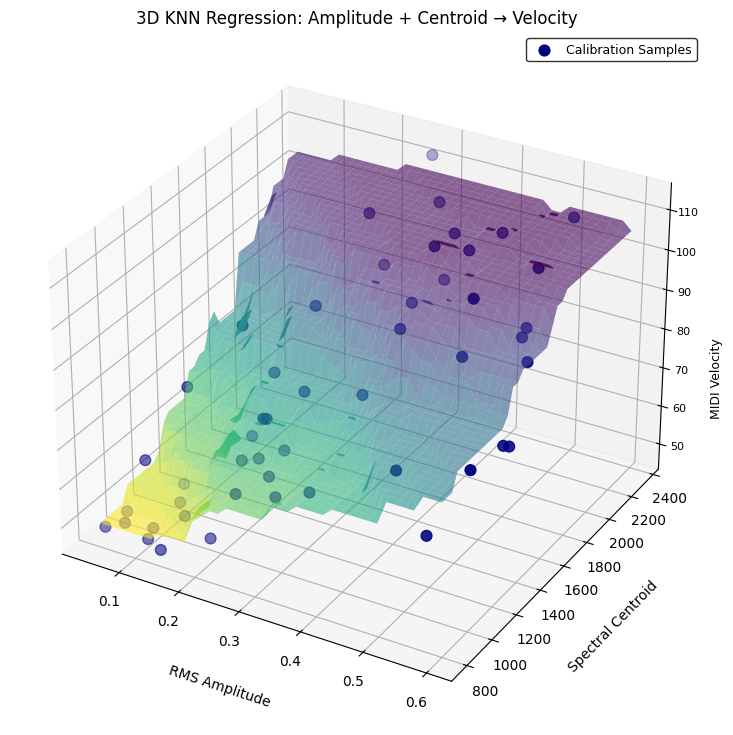

In [ ]:
features, labels = load_calibration_data()
model = train_knn_model(features, labels)
plot_model_3d(features, labels, model)


✅ Best KNN parameters: {'knn__n_neighbors': 8, 'knn__weights': 'uniform'}
🎯 Final KNN Accuracy: 85.07% (RMSE: 9.55)


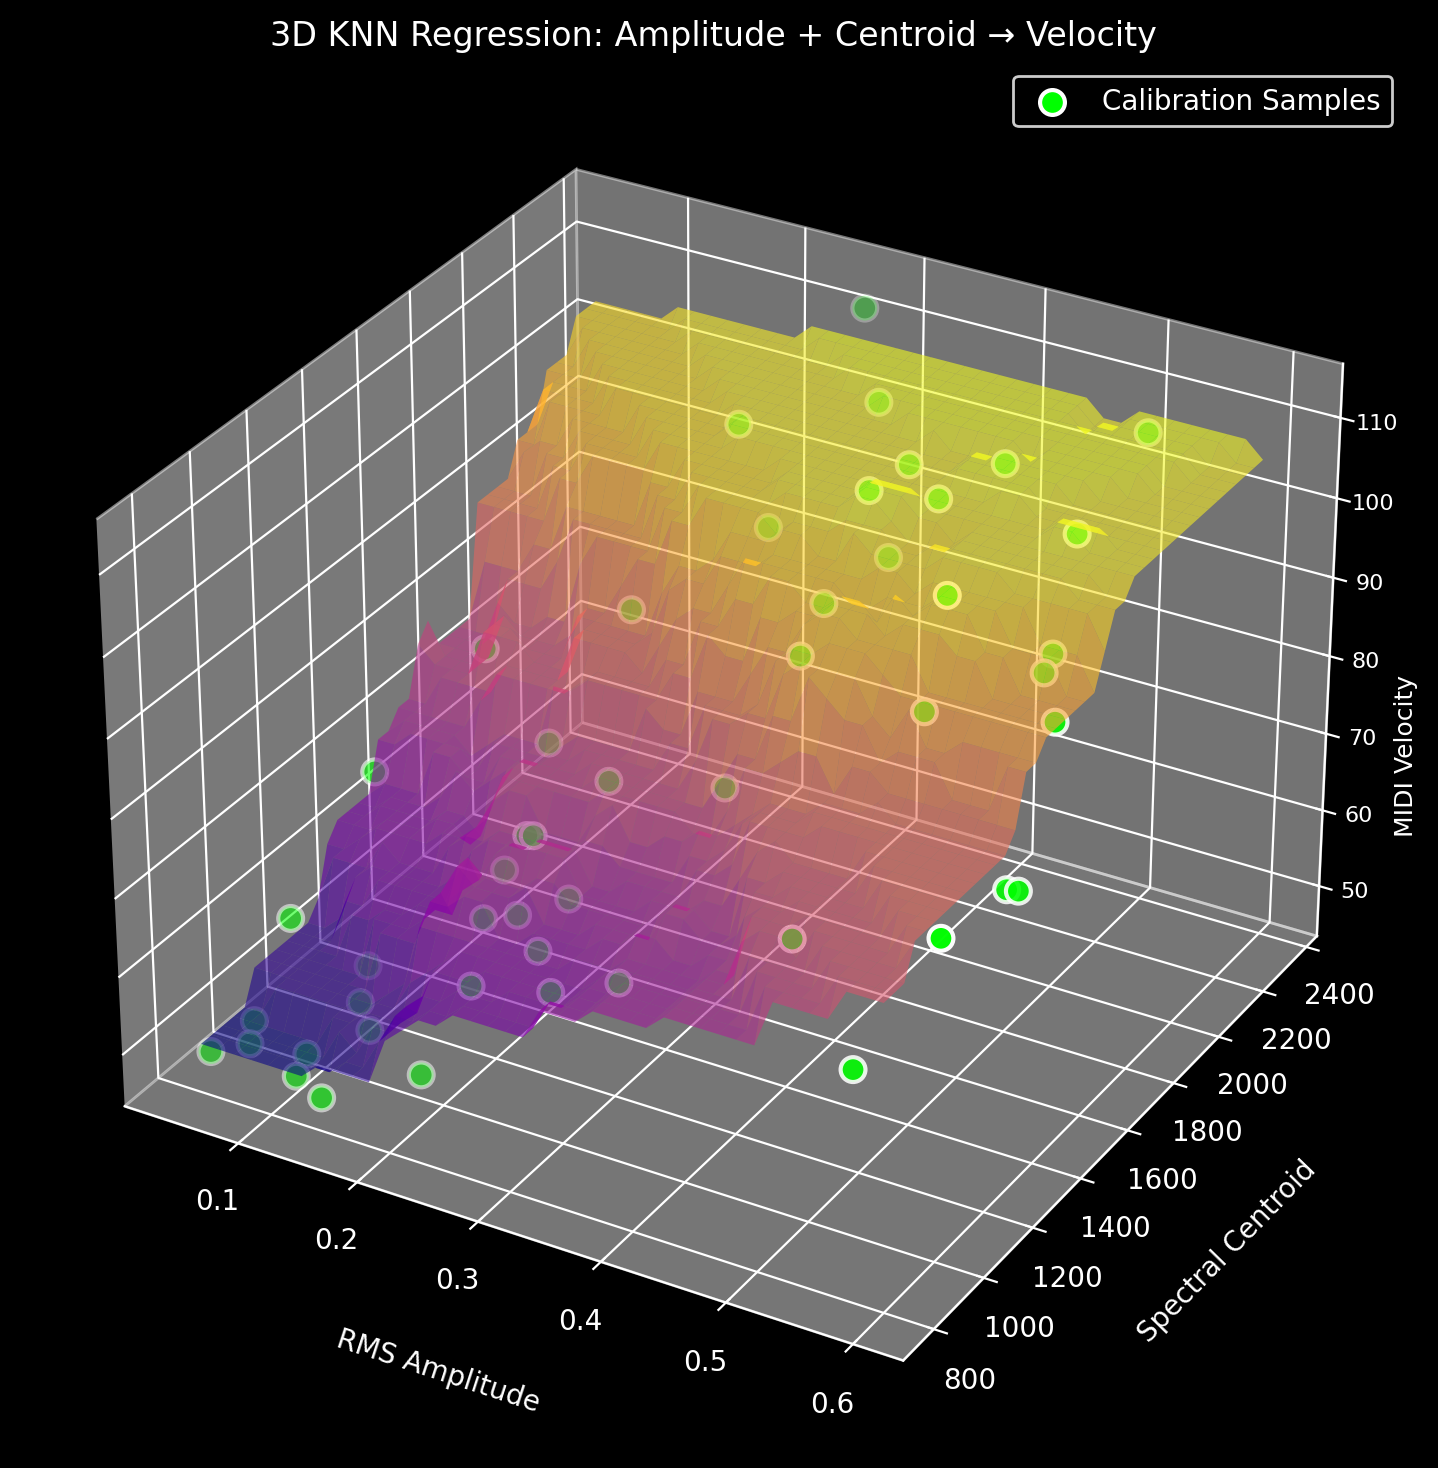

⚠️ Performance ID n46 missing from onset data.
❌ Error estimating velocity for n86: Audio is completely silent.
❌ Error estimating velocity for n88: Audio is completely silent.
❌ Error estimating velocity for n95: Audio is completely silent.
❌ Error estimating velocity for n92: Audio is completely silent.
❌ Error estimating velocity for n102: Audio is completely silent.
⚠️ Performance ID n105 missing from onset data.
⚠️ Performance ID n109 missing from onset data.
🎧 Dynamics Evaluation Result:
✔️ Accuracy: 71.65%
📉 Mean Velocity Error: 18.00

🎯 Predicted Velocities vs Score Velocities:

  Note  1:  Predicted =  78 | Score =  96 | Error = 18


/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=354
  warnings.warn(


In [ ]:
score_velocities = extract_note_velocities(score_filename)
pna_dyn_onsets = build_pna_dyn_onsets(filtered_alignment, original_pna)
matches_only = [
    match for match in pred_alignment
    if match.get('label') == 'match'
]
features, labels = load_calibration_data()
model = train_knn_model(features, labels)
plot_model_3d(features, labels, model)

result = evaluate_dynamics_from_alignment(
    pred_alignment=matches_only,
    pna_dyn_onsets=pna_dyn_onsets,
    score_velocities=score_velocities,
    audio_filename= audio_filename,
    model=model
)
dynamics_accuracy = result['dynamics_accuracy']
predicted_velocities = result['predicted_velocities']
score_velocities = result['score_velocities']
def print_dynamics_result(result):
    print("Dynamics Evaluation Result:")
    print(f"Accuracy: {result['dynamics_accuracy']:.2f}%")
    print(f"Mean Velocity Error: {result['mean_velocity_error']:.2f}")
    print("\nPredicted Velocities vs Score Velocities:\n")
    for i, (p, s) in enumerate(zip(result['predicted_velocities'], result['score_velocities'])):
        diff = abs(p - s)
        print(f"  Note {i + 1:>2}:  Predicted = {p:>3} | Score = {s:>3} | Error = {diff:>2}")

print_dynamics_result(result)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

def plot_linear_regression(features, labels):
    x = features[:, 0]
    y = labels

    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)

    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(8, 8))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    ax.scatter(
        x, y,
        c='navy',
        s=70,
        label='Calibration Samples'
    )

    x_line = np.linspace(min(x), max(x), 300)
    y_line = model.predict(x_line.reshape(-1, 1))
    y_line = np.clip(y_line, 40, 120)

    points = np.column_stack([x_line, y_line])
    segments = np.stack([points[:-1], points[1:]], axis=1)
    norm = Normalize(vmin=x_line.min(), vmax=x_line.max())
    lc = LineCollection(segments, cmap='viridis_r', norm=norm, linewidth=2)
    lc.set_array(x_line[:-1].ravel())
    ax.add_collection(lc)

    ax.set_xlabel('RMS Amplitude', color='black', labelpad=10)
    ax.set_ylabel('MIDI Velocity', color='black', labelpad=10)
    ax.set_title('Linear Regression: RMS Amplitude → MIDI Velocity', color='black')

    ax.legend(facecolor='white', edgecolor='black', fontsize=10, loc='upper left')
    ax.tick_params(axis='both', colors='black', labelsize=10)
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.6)

    ax.set_xlim(min(x_line), max(x_line))
    ax.set_ylim(40, 120)

    plt.show()


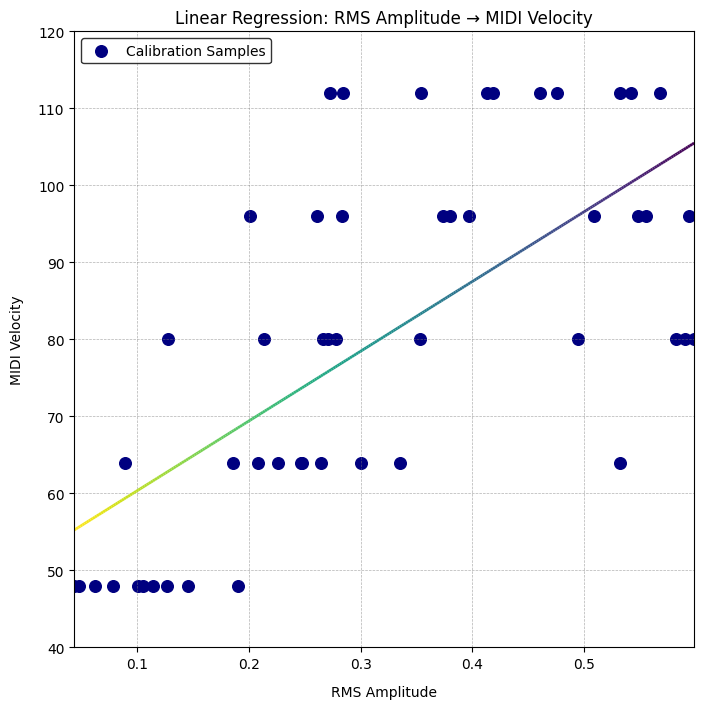

In [ ]:

plot_linear_regression(features, labels)

# **LLM Prompting**

In [ ]:
import numpy as np

def compile_note_alignment(
    sna_match, pna_match, filtered_alignment,
    score_velocities, predicted_velocities,
    timing_accuracy, pitch_accuracy, dynamics_accuracy, bpm,
    filtered_errors
):
    if isinstance(score_velocities, list):
        score_velocities = {f'n{i}': v for i, v in enumerate(score_velocities)}

    if isinstance(predicted_velocities, list):
        predicted_velocities = {f'n{i}': v for i, v in enumerate(predicted_velocities)}

    seconds_per_beat = 60 / bpm

    score_dict = {str(note['id']): note for note in sna_match}
    perf_dict = {str(note['id']): note for note in pna_match}

    compiled = []

    for idx, pair in enumerate(filtered_alignment):
        if 'score_id' not in pair or 'performance_id' not in pair:
            continue
        score_id = str(pair['score_id'])
        perf_id = str(pair['performance_id'])

        if score_id not in score_dict or perf_id not in perf_dict:
            continue

        score_note = score_dict[score_id]
        perf_note = perf_dict[perf_id]

        score_onset_beats = score_note['onset_beat']
        score_onset_sec = score_onset_beats * seconds_per_beat
        perf_onset_sec = perf_note['onset_sec']

        if idx < len(filtered_errors):
            onset_error_sec = filtered_errors[idx] * seconds_per_beat
        else:
            raise ValueError("Mismatch: filtered_errors length doesn’t match filtered_alignment")

        score_vel = score_velocities.get(score_id, -1)
        perf_vel = predicted_velocities.get(perf_id, -1)
        vel_error = abs(perf_vel - score_vel)

        pitch_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
        score_pitch = score_note['pitch']
        perf_pitch = perf_note['pitch']
        score_note_name = f"{pitch_names[score_pitch % 12]}{score_pitch // 12 - 1}"
        perf_note_name = f"{pitch_names[perf_pitch % 12]}{perf_pitch // 12 - 1}"

        pitch_error = (perf_pitch - score_pitch)

        compiled.append({
            'note': score_id,
            'score_onset': round(score_onset_sec, 5),
            'perf_onset': round(perf_onset_sec, 5),
            'onset_error': round(onset_error_sec, 5),
            'score_vel': score_vel,
            'perf_vel': perf_vel,
            'vel_error': vel_error,
            'score_pitch': score_note_name,
            'perf_pitch': perf_note_name,
            'pitch_error': pitch_error
        })

    summary = {
        'timing_accuracy': timing_accuracy,
        'pitch_accuracy': pitch_accuracy,
        'dynamics_accuracy': dynamics_accuracy
    }

    return compiled, summary


def compute_overall_score(
    pitch_accuracy, timing_accuracy, dynamics_accuracy,
    pitch_weight=0.4, timing_weight=0.4, dynamics_weight=0.2
):
    return (
        pitch_weight * pitch_accuracy +
        timing_weight * timing_accuracy +
        dynamics_weight * dynamics_accuracy
    )


In [ ]:
trimmed_filtered_alignment = [
    match for match in filtered_alignment
    if match.get('label') == 'match'
]
compiled, summary = compile_note_alignment(sna_match, pna_match, trimmed_filtered_alignment, score_velocities, predicted_velocities, timing_accuracy, pitch_accuracy, dynamics_accuracy, bpm, filtered_errors)
overall = compute_overall_score(pitch_accuracy, timing_accuracy, dynamics_accuracy)

In [ ]:
!pip install --upgrade openai
!pip install python-dotenv

from openai import OpenAI

ERROR: Operation cancelled by user


In [ ]:

import os
from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def generate_marimba_prompt(compiled, summary, bpm, overall_score):
    seconds_per_beat = 60 / bpm if bpm else None
    timing_threshold = round(0.2 * seconds_per_beat, 3) if seconds_per_beat else "a short margin"

    static_instruction = f"""
    You are an expert marimba and mallet percussion instructor. A student has just performed a passage, and you are provided note-level data including:

Onset timing error (in seconds, already filtered to remove extreme outliers)

Pitch error (in semitones)

Dynamic (velocity) error

Your task is to provide professional, constructive feedback exactly as you would in a private lesson for a serious high school or college student. Your goal is for the student to:

Understand their performance clearly

Know what they did well

Know what to focus on in practice

Do not provide numeric grades or report-card style feedback.

Instructions

Analyze both individual notes and broader patterns.

Highlight specific note-level errors that stand out, explaining their potential technical causes.

Identify trends across phrases, registers, hands, or intervals, and point out recurring tendencies.

Always refer to notes using score_pitch and perf_pitch (e.g., C4, F#5), never by note numbers (e.g., n1, n2).

Timing / Rhythm

Note if the performer tends to rush, drag, or maintain steady time.

Consider changes in timing across registers, transitions, or phrase beginnings.

Suggest targeted practice strategies for both isolated problematic notes and recurring patterns.

Pitch / Intonation

Identify isolated pitch errors and intervals that consistently deviate.

Connect errors to technical causes like hand position, mallet angle, or balance.

Suggest practice that addresses both one-off mistakes and systematic tendencies.

Dynamics / Expression

Observe trends and outliers in dynamics: soft passages, accents, and crescendos.

Recommend ways to improve individual notes and overall expressive shaping.

Articulation / Phrasing

Highlight clarity of strokes, lifts, and accents on specific notes.

Connect phrasing trends to musical understanding and expressive goals.

Recommend exercises that improve both note-level articulation and larger musical phrasing.

Recurring or Structural Challenges

Identify repeated technical or musical challenges: transitions, fast passages, hand crossings.

Suggest stepwise practice: isolate tricky notes, then integrate into phrases, then work on entire sections.

Tone and Style

Begin by acknowledging strengths, both at the note-level and in overall patterns.

Use a descriptive, musically insightful tone, connecting technical observations to how the performance sounds and feels.

Avoid numeric scores, percentages, or abstract metrics.

Make feedback feel like a real lesson conversation, actionable and motivating.

Emphasize both isolated note corrections and trend-based improvements, helping the student address the most impactful aspects of their playing.
    """

    summary_section = "\n### Summary Metrics:\n"
    summary_section += f"- Pitch Accuracy: {summary['pitch_accuracy']:.2f}%\n"
    summary_section += f"- Timing Accuracy: {summary['timing_accuracy']:.2f}%\n"
    summary_section += f"- Dynamics Accuracy: {summary['dynamics_accuracy']:.2f}%\n"
    if overall_score is not None:
        summary_section += f"- Overall Score: {overall_score:.2f}/100\n"

    compiled_section = "\n### Per-note Analysis (Raw Alignment Data):\n"
    for note in compiled:
        compiled_section += (
            f"{note['note']}: "
            f"onset_error = {note['onset_error']:.3f}s, "
            f"pitch_error = {note['pitch_error']}, "
            f"velocity_error = {note['vel_error']}, "
            f"score_pitch = {note['score_pitch']}, "
            f"perf_pitch = {note['perf_pitch']}\n"
        )
    return static_instruction + "\n" + summary_section + "\n" + compiled_section

def get_marimba_feedback(prompt, model="gpt-4o-mini"):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are an expert marimba and mallet percussion instructor."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7
    )
    return response.choices[0].message.content

prompt = generate_marimba_prompt(compiled, summary, bpm, overall)
feedback = get_marimba_feedback(prompt)

print("Feedback:\n")
print(feedback)


🎵 Feedback:

First, I want to commend you on your performance! You achieved an impressive pitch accuracy of 97.37%, which indicates that you have a solid sense of the pitches in the piece. Your timing accuracy is also commendable at 90.79%, suggesting that you maintain a good sense of rhythm throughout most of your performance. However, there are certain areas we can work on to enhance your expressiveness and overall musicality, particularly in dynamics, which showed a lower accuracy of 46.64%. 

### Specific Highlights

**What You Did Well:**
- Your pitch accuracy is very high, with only two isolated pitch errors (C5 played as B4 and D5 played as E5). These need attention, but overall your intonation is strong.
- Your timing is consistent, especially in the majority of notes where you demonstrated no onset timing errors. This steadiness is crucial for ensemble playing and contributes to a more polished sound.

### Areas for Improvement

#### Timing / Rhythm:
- While you maintained ste

In [ ]:
print("Final Scores:\n")
print(f"- Pitch Accuracy: {summary['pitch_accuracy']:.2f}%\n")
print(f"- Timing Accuracy: {summary['timing_accuracy']:.2f}%\n")
print(f"- Dynamics Accuracy: {summary['dynamics_accuracy']:.2f}%\n")
print(f"- Overall Weighted Score: {overall:.2f}/100\n")

Final Scores:

- Pitch Accuracy: 100.00%

- Timing Accuracy: 82.86%

- Dynamics Accuracy: 83.81%

- Overall Weighted Score: 89.91/100

